In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/metrics.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def import_all_metrics_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/metrics.json`, returning a dictionary that maps
    `{run_num}` to the metrics dictionary.
    """
    all_metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_metrics = {key : val for key, val in all_metrics.items() if val}  # Remove empties
    return all_metrics

In [4]:
def import_config_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/config.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "config.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [5]:
def import_all_config_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/config.json`, returning a dictionary that maps
    `{run_num}` to the config dictionary.
    """
    all_config = {run_num : import_config_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_config = {key : val for key, val in all_config.items() if val}  # Remove empties
    return all_config

In [6]:
def extract_metrics_values(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key.
    """
    return metrics[key]["values"]

In [7]:
def extract_metrics_values_at_best_val(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key, but only for
    the epoch that yielded the minimal validation loss. It is assumed that
    the requested key is saved once per epoch.
    """
    best_epoch = np.argmin(extract_metrics_values(metrics, "val_epoch_loss"))
    return extract_metrics_values(metrics, key)[best_epoch]

In [8]:
def smooth_signal(signal, sigma, axis=-1):
    """
    Smooths a signal along the given axis using a Gaussian weight vector.
    Smooths to 1 sigma (unless sigma is 0, and then it does no smoothing).
    """
    if sigma == 0:
        return scipy.ndimage.gaussian_filter1d(signal, 1, axis=axis, truncate=0)
    else:
        return scipy.ndimage.gaussian_filter1d(signal, sigma, axis=axis, truncate=1)

In [10]:
noprior_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1/"
prior_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior/"

noprior_metrics = import_all_metrics_json(noprior_models_path)
prior_metrics = import_all_metrics_json(prior_models_path)

noprior_config = import_all_config_json(noprior_models_path)
prior_config = import_all_config_json(prior_models_path)

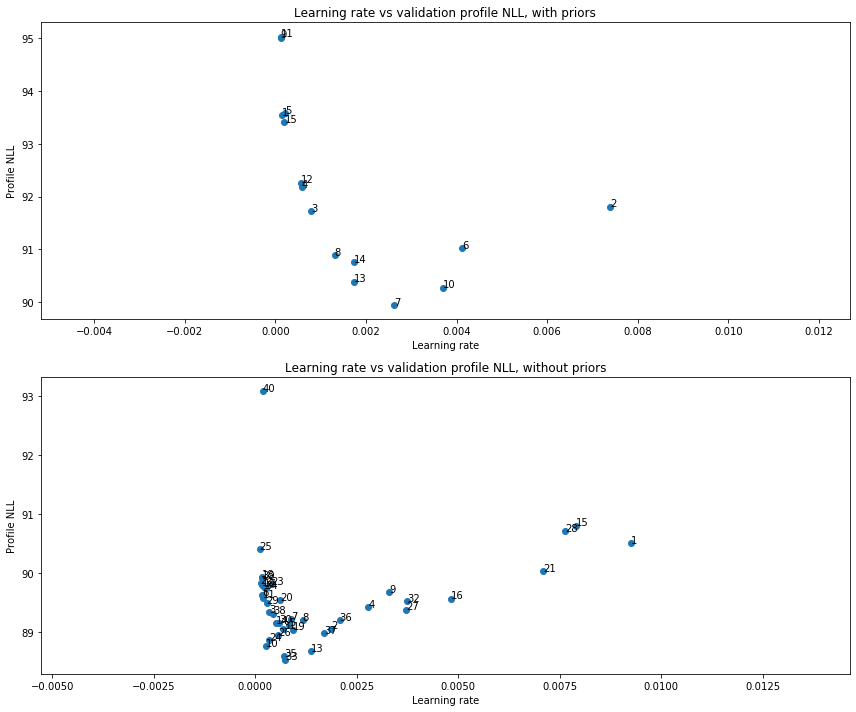

In [14]:
# Profile loss vs learning rate
noprior_keys = sorted(set(noprior_metrics.keys()) & set(noprior_config.keys()))
prior_keys = sorted(set(prior_metrics.keys()) & set(prior_config.keys()))
noprior_nll, prior_nll = [], []
noprior_lr, prior_lr = [], []
noprior_labels, prior_labels = [], []
for key in noprior_keys:
    try:
        noprior_nll.append(
            np.mean(extract_metrics_values_at_best_val(noprior_metrics[key], "val_prof_corr_losses"))
        )
        noprior_lr.append(noprior_config[key]["learning_rate"])
        noprior_labels.append(key)
    except KeyError:
        pass
for key in prior_keys:
    try:
        prior_nll.append(
            np.mean(extract_metrics_values_at_best_val(prior_metrics[key], "val_prof_corr_losses"))
        )
        prior_lr.append(prior_config[key]["learning_rate"])
        prior_labels.append(key)
    except KeyError:
        pass

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].scatter(prior_lr, prior_nll)
ax[0].set_title("Learning rate vs validation profile NLL, with priors")
ax[0].set_xlabel("Learning rate")
ax[0].set_ylabel("Profile NLL")
for i, key in enumerate(prior_labels):
    ax[0].annotate(key, (prior_lr[i], prior_nll[i]))
ax[1].scatter(noprior_lr, noprior_nll)
ax[1].set_title("Learning rate vs validation profile NLL, without priors")
ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Profile NLL")
for i, key in enumerate(noprior_labels):
    ax[1].annotate(key, (noprior_lr[i], noprior_nll[i]))
fig.tight_layout()

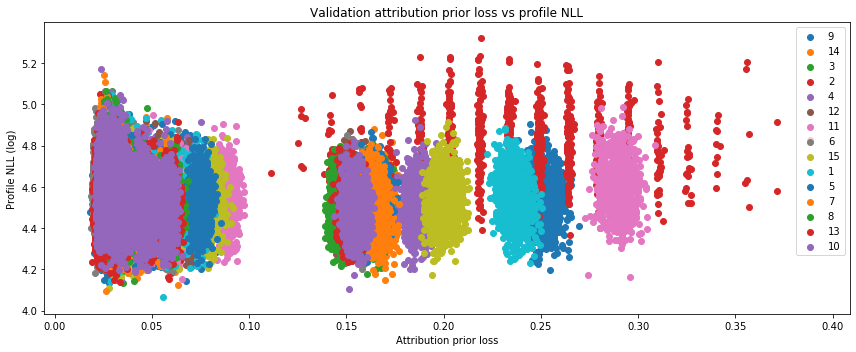

In [16]:
# Profile loss vs attribution prior loss
nlls = []
pos_losses = []
labels = []
for key in prior_metrics.keys():
    try:
        nlls.append(
            np.log(np.ravel(np.array(extract_metrics_values(prior_metrics[key], "val_prof_corr_losses"))))
        )
        pos_losses.append(
            np.ravel(np.array(extract_metrics_values(prior_metrics[key], "val_pos_att_losses")))
        )
        labels.append(key)
    except KeyError:
        pass

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for i, label in enumerate(labels):
    ax.scatter(pos_losses[i], nlls[i], label=label)
    ax.set_title("Validation attribution prior loss vs profile NLL")
    ax.set_xlabel("Attribution prior loss")
    ax.set_ylabel("Profile NLL (log)")
plt.legend()
fig.tight_layout()

Text(0.5, 1.0, 'Validation epoch losses with and without prior')

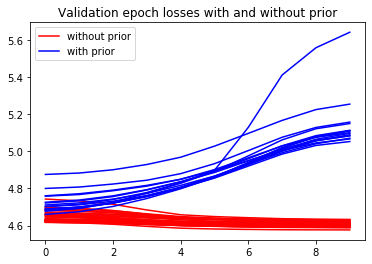

In [17]:
# Plot validation epoch losses with and without prior
noprior_val_epoch_losses = {key : extract_metrics_values(m, "val_epoch_loss") for key, m in noprior_metrics.items()}
prior_val_epoch_losses = {key : extract_metrics_values(m, "val_epoch_loss") for key, m in prior_metrics.items()}
plt.figure()
for key, epoch_losses in noprior_val_epoch_losses.items():
    line = smooth_signal(np.log(epoch_losses), 3)
    noprior_line, = plt.plot(line, color="red")
for key, epoch_losses in prior_val_epoch_losses.items():
    line = smooth_signal(np.log(epoch_losses), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation epoch losses with and without prior")

Text(0.5, 1.0, 'Validation correctness losses with and without prior')

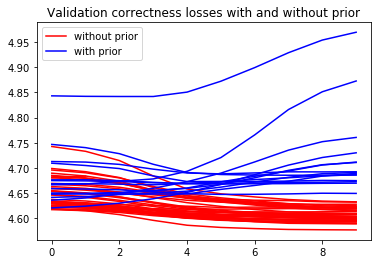

In [18]:
# Plot validation correctness losses with and without prior
noprior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in noprior_metrics.items()}
prior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, corr_losses in noprior_val_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_val_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation correctness losses with and without prior")

Text(0.5, 1.0, 'Validation profile correctness losses with and without prior')

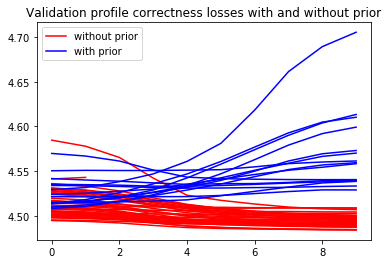

In [19]:
# Plot validation profile losses with and without prior
noprior_val_prof_corr_losses = {key : extract_metrics_values(m, "val_prof_corr_losses") for key, m in noprior_metrics.items()}
prior_val_prof_corr_losses = {key : extract_metrics_values(m, "val_prof_corr_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, prof_corr_losses in noprior_val_prof_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(prof_corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, prof_corr_losses in prior_val_prof_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(prof_corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation profile correctness losses with and without prior")

Text(0.5, 1.0, 'Validation attribution losses with prior')

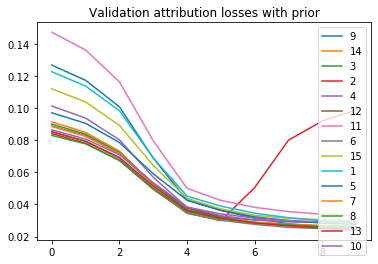

In [21]:
# Plot validation attribution losses with prior
prior_val_att_losses = {key : extract_metrics_values(m, "val_att_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, att_losses in prior_val_att_losses.items():
    line = smooth_signal(np.nanmean(att_losses, axis=1), 3)
    prior_line, = plt.plot(line, label=key)
plt.legend()
plt.title("Validation attribution losses with prior")

Text(0.5, 1.0, 'Validation batch losses with and without prior')

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


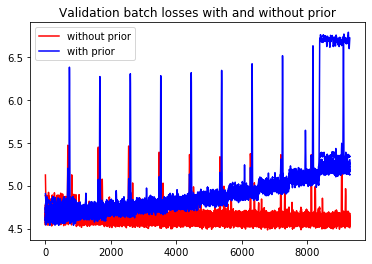

In [22]:
# Plot validation batch losses with and without prior
noprior_val_batch_losses = {key : extract_metrics_values(m, "val_batch_losses") for key, m in noprior_metrics.items()}
prior_val_batch_losses = {key : extract_metrics_values(m, "val_batch_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, batch_losses in noprior_val_batch_losses.items():
    line = smooth_signal(np.log(np.concatenate(batch_losses)), 10)
    noprior_line, = plt.plot(line, color="red")
for key, batch_losses in prior_val_batch_losses.items():
    line = smooth_signal(np.log(np.concatenate(batch_losses)), 10)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation batch losses with and without prior")

IndexError: list index out of range

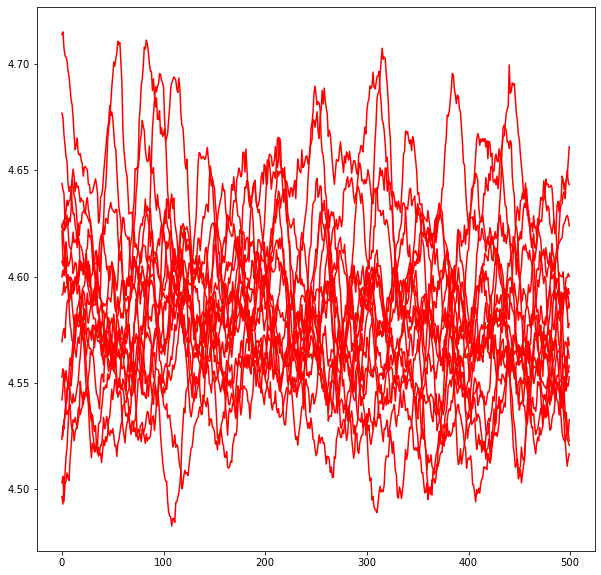

In [23]:
# Plot training correctness losses with and without prior
noprior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_metrics.items()}
prior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_metrics.items()}
plt.figure(figsize=(10, 10))
for key, corr_losses in noprior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[1][:500]), 10)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[1][:500]), 10)
    prior_line, = plt.plot(line, color=("green" if key == "3" else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses with and without prior, first 100 batches of epoch 1")

Text(0.5, 1.0, 'Training correctness losses on noise with and without prior')

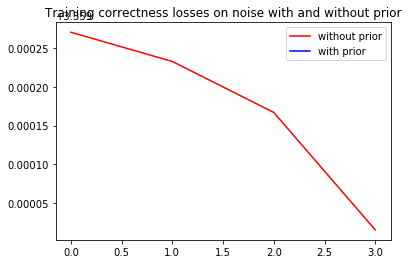

In [16]:
# Plot training correctness losses on noise with and without prior
noprior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_noisy_metrics.items()}
prior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_noisy_metrics.items()}
plt.figure()
for key, corr_losses in noprior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses on noise with and without prior")

Text(0.5, 1.0, 'Training correctness losses on noise with and without prior, first 100 batches of epoch 1')

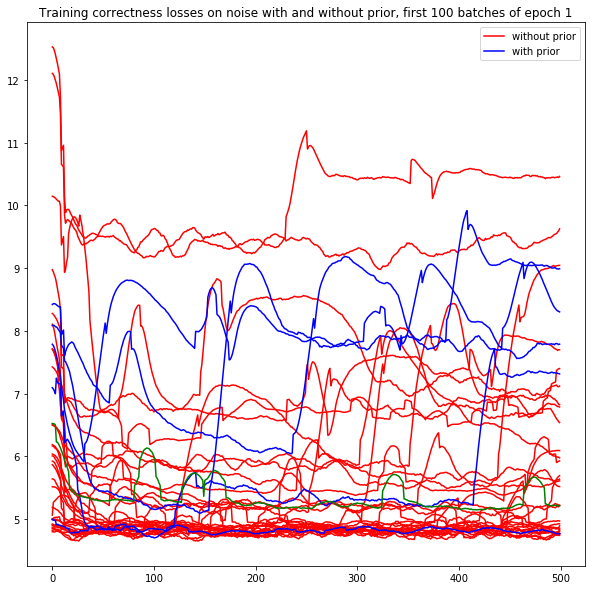

In [33]:
# Plot training correctness losses on noise with and without prior
noprior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_noisy_metrics.items()}
prior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_noisy_metrics.items()}
plt.figure(figsize=(10, 10))
for key, corr_losses in noprior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:500]), 10)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:500]), 10)
    prior_line, = plt.plot(line, color=("green" if key == "1" else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses on noise with and without prior, first 100 batches of epoch 1")

In [17]:
[(key, len(m)) for key, m in prior_val_corr_losses.items()]

[('3', 20), ('2', 20), ('4', 20), ('1', 20), ('5', 16)]

In [ ]:
# prior_val_epoch_losses["17"]
np.any(np.isnan(prior_val_corr_losses["17"]))
prior_val_att_losses["17"]

In [ ]:
for m in prior_val_att_losses.values():
    print(np.any(np.isnan(m)))